# Pansharpening Landsat using `xr_pansharpen` <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/ga_ls8c_ard_3), [ga_ls7e_ard_3](https://explorer.dea.ga.gov.au/ga_ls7e_ard_3)

## Background

Panchromatic sharpening ("pansharpening") is an image processing technique used to increase the spatial resolution of an image by combining a higher resolution "panchromatic" band with lower resolution multispectral bands. 
The resulting image has both the higher spatial resolution of the panchromatic band, and the spectral information of the multispectral bands.

Satellite instruments are designed to capture images at a certain signal-to-noise ratio. 
Compared to multispectral satellite bands that cover multiple narrow portions of the electromagnetic spectrum, a panchromatic satellite band covers a wide spectral range that overlaps with multiple multispectral bands.
This wider spectral range allows panchromatic bands to receive more energy per pixel than the multispectral bands. 
This means that compared to multispectral bands, panchromatic bands can be collected at a higher spatial resolution while still meeting the satellite instrument's signal-to-noise threshold.

Since Landsat 7, Landsat satellite sensors have included a 15 metre resolution panchromatic band.
Using pansharpening, we can use this band to increase the spatial resolution of Landsat multispectral bands from their usual 30 metre resolution to 15 metre resolution, resulting in higher resolution multispectral data.


## Description
In this example we will load Landsat data, and demonstrate how to improve its spatial resolution from 30 to 15 metres using several common pansharpening transforms implemented using the `xr_pansharpen` function from `dea_tools.data_handling`:

1. [Define our area of interest](#Analysis-parameters)
2. [Load in a single true colour Landsat 8 image](#Loading-data)
3. [Apply the Brovey transform to pansharpen our data](#Apply-Brovey-pansharpening)
4. [Explore and compare multiple pansharpening methods](#Other-pansharpening-methods)
5. [Automatically apply pansharpening to multiple timesteps/images](#Pansharpening-multiple-timesteps/images)
6. [Pansharpen false colour Landsat 7 imagery using the NIR band](#Pansharpening-Landsat-7)
7. [Advanced: Evaluate the performance of pansharpening algorithms](#Advanced)

***

## Getting started

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import cv2
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../Tools/")
from dea_tools.datahandling import mostcommon_crs, load_ard, xr_pansharpen
from dea_tools.plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data:

In [2]:
dc = datacube.Datacube(app="Pansharpening")

### Analysis parameters

First we define a spatio-temporal Datacube query to load data over Parliament House in Canberra for a specific date:


In [3]:
# Parliament House, Canberra
query = {
    "x": (149.12, 149.144),
    "y": (-35.312, -35.29),
    "time": ("2020-05-07"),
}

### Determine native resolution
Pansharpening works best if our data is loaded as close as possible to its original pixel size and alignment, with no additional reprojection or resampling.

This section ensures your data is loaded in its "native projection"; i.e. the projection the data is stored in on file.
This will ensure maximum fidelity of your data by preventing data from being needlessly re-projected when loaded.

In [4]:
output_crs = mostcommon_crs(dc=dc, query=query, product="ga_ls8c_ard_3")
output_crs

'epsg:32655'

## Loading data
As our first step, we need to load our multispectral data into the 15 x 15 metre resolution of Landsat's panchromatic band so that all of our pixels are lined up. 
To do this, we load the red, green, blue and panchromatic bands at 15 m resolution (using `resolution=(-15, 15)`), resampling the data using bilinear resampling (`resampling="bilinear"`).
This resampling step doesn't apply any sharpening of its own, but simply smooths out our multispectral data so it's more compatible with the higher resolution panchromatic band. 

To re-create the exact pixel grid of our data on file, we also need to supply a half-pixel offset using `align=(7.5, 7.5)` (for more information on using `align`, see the [Introduction to DEA Surface Reflectance (Landsat, Collection 3)](../DEA_products/DEA_Landsat_Surface_Reflectance.ipynb#Using-the-align-parameter-when-natively-loading-data) notebook).

In [5]:
# Load red, green, blue and panchromatic band data at 15 m resolution
rgbp_15m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_panchromatic"],
    output_crs=output_crs,
    resolution=(-15, 15),
    align=(7.5, 7.5),
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 1 time steps


/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


For reference, we can also load our multispectral bands in their original 30 x 30 metre pixel resolution:

In [6]:
# For reference, load the same image at 30 m resolution
rgb_30m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    output_crs=output_crs,
    resolution=(-30, 30),
    align=(15, 15),
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 1 time steps


### Visualise the panchromatic band
To visualise how the spatial resolution of Landsat's panchromatic band compares to the spatial resolution of the red, green and blue bands, we can plot both options. 
In the example below, we plot the 30 m Landsat 8 green band on the left, and the 15 m panchromatic band on the right. 
It should be clear how much additional spatial detail is visible in the panchromatic band.

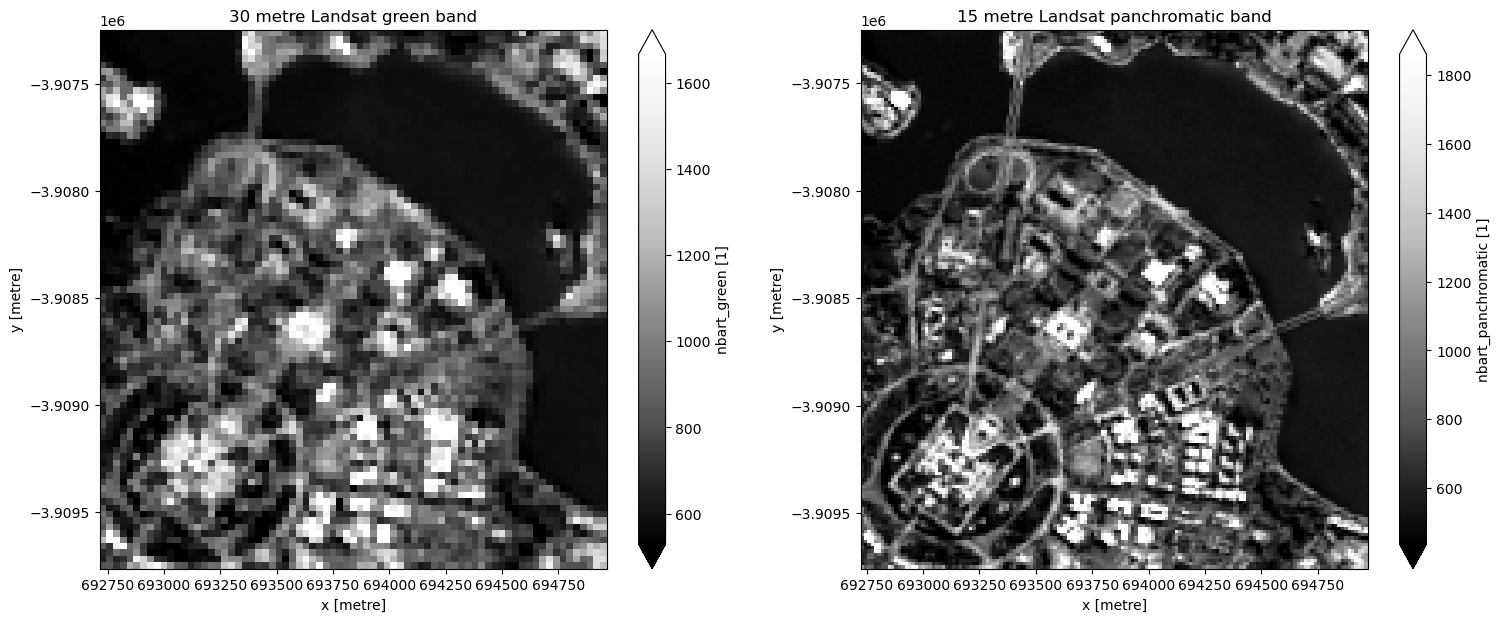

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
rgb_30m.nbart_green.plot(ax=axes[0], cmap="Greys_r", robust=True)
rgbp_15m.nbart_panchromatic.plot(ax=axes[1], cmap="Greys_r", robust=True)
axes[0].set_title("30 metre Landsat green band")
axes[1].set_title("15 metre Landsat panchromatic band");

## Apply Brovey pansharpening
To demonstrate how to apply pansharpening with `xr_pansharpen`, we will first apply a popular pansharpening method called the **Brovey transform**. 

Brovey pansharpening is a simple algorithm designed to optimise visual contrast at both ends of the satellite imagery's histogram.
The approach multiplies each multispectral pixel by the ratio of the panchromatic pixel intensity to the sum of all multispectral pixel intensities. [(source)](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/fundamentals-of-pan-sharpening-pro.htm).
Brovey pansharpening is primarily used for visual analysis as it isn't guaranteed to maintain spectral integrity of the input data.

> **Note:** Because Landsat 8 and 9's Blue band only slightly overlaps with the panchromatic band, `xr_pansharpen` applies a weighted sum of the multispectral bands in the Brovey calculation: Red and Green are both weighted 40%, and Blue is weighted 20%. 
This can be customised using the `band_weights` parameter.

In [8]:
# Perform Brovey pansharpening 
rgb_brovey_15m = xr_pansharpen(rgbp_15m, transform="brovey")


Applying Brovey pansharpening


### Plot and compare pansharpened data to original data

To evaluate our pan-sharpened image, we can compare it with our previously loaded reference data.
In the image below, we plot our original 30 m resolution reference data, the resampled but not pansharpened 15 m resolution input data, and finally our 15 m pansharpened image:

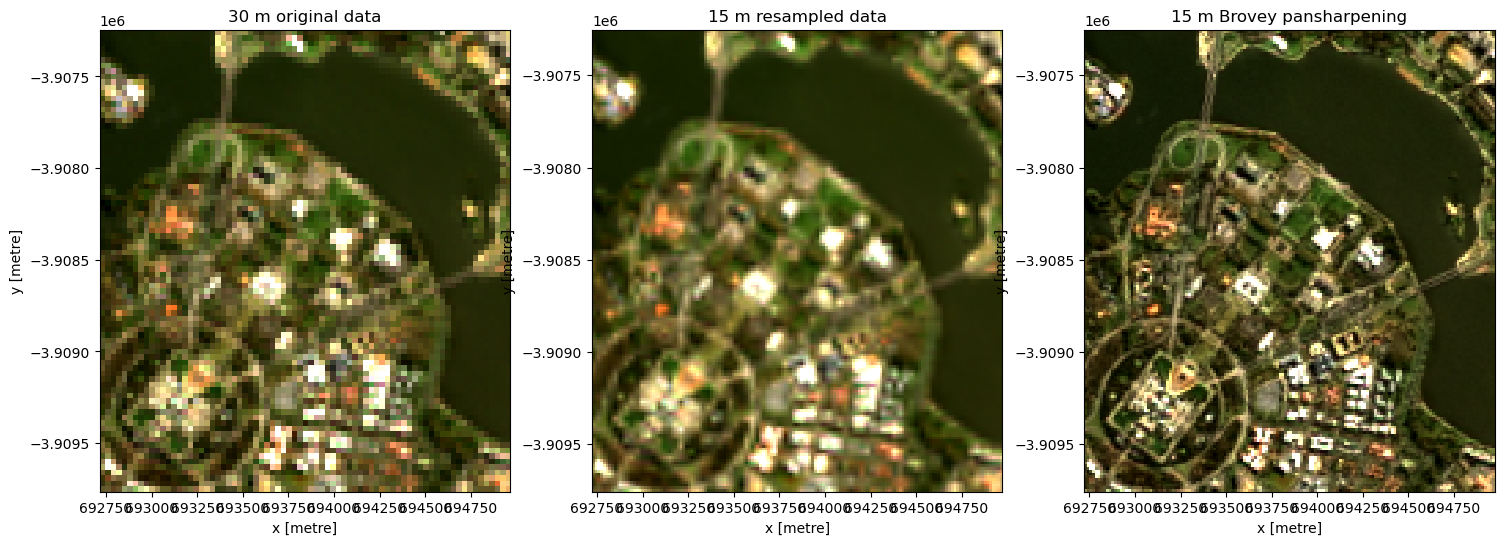

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
rgb(ds=rgb_30m, ax=axes[0])
rgb(ds=rgbp_15m, ax=axes[1])
rgb(ds=rgb_brovey_15m, ax=axes[2])
axes[0].set_title("30 m original data")
axes[1].set_title("15 m resampled data")
axes[2].set_title("15 m Brovey pansharpening");

Looking at the images above, the pansharpened image appears sharp and detailed, while still retaining the multispectral data (i.e. RGB colours) that were not originally included in the panchromatic band.

## Other pansharpening methods

The `xr_pansharpen` function currently supports several other common pansharpening methods, including:

* **Simple mean ("simple mean"):** Takes the average of each low resolution multispectral band and the panchromatic band [(source)](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/fundamentals-of-pan-sharpening-pro.htm).
* **ESRI ("esri"):** Takes the mean of the all low resolution multispectral bands, then subtracts this from the higher panchromatic band to produce an "adjustment factor" which is then added back to each band [(source)](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/fundamentals-of-pan-sharpening-pro.htm).
* **Hue Saturation Value ("hsv"):** Converts low resolution image data from RGB to HSV colour space, where "V" represents "Value", or the relative lightness or darkness of the image. 
This band is replaced with the higher resolution panchromatic band, then converted back to the original RGB colour space. 
Note that this method is only suitable for pansharpening data containing RGB bands, so should not be used to pansharpen Near Infrared data from Landsat 7 [(source)](https://doi.org/10.1109/TGRS.2014.2361734).
* **Principal Components Analysis ("pca"):** transforms low resolution original data into its principal components, then substitutes the first principal component with the higher resolution panchromatic band [(source)](https://doi.org/10.1109/TGRS.2014.2361734).


> **Note:**  Pan-sharpening transforms do not necessarily maintain the spectral integrity of the input satellite data, and may be more suitable for visualisation than quantitative analysis.
We recommend you investigate the performance of all these methods for your specific application before making a selection.
See the [Evaluating pansharpening method performance](#Evaluating-pansharpening-method-performance) section for one example of how to compare different pansharpening algorithms.


In [10]:
rgb_simplemean_15m = xr_pansharpen(rgbp_15m, transform="simple mean")
rgb_esri_15m = xr_pansharpen(rgbp_15m, transform="esri")
rgb_hsv_15m = xr_pansharpen(rgbp_15m, transform="hsv")
rgb_pca_15m = xr_pansharpen(rgbp_15m, transform="pca")

Applying Simple mean pansharpening
Applying Esri pansharpening
Applying HSV pansharpening
Applying PCA pansharpening


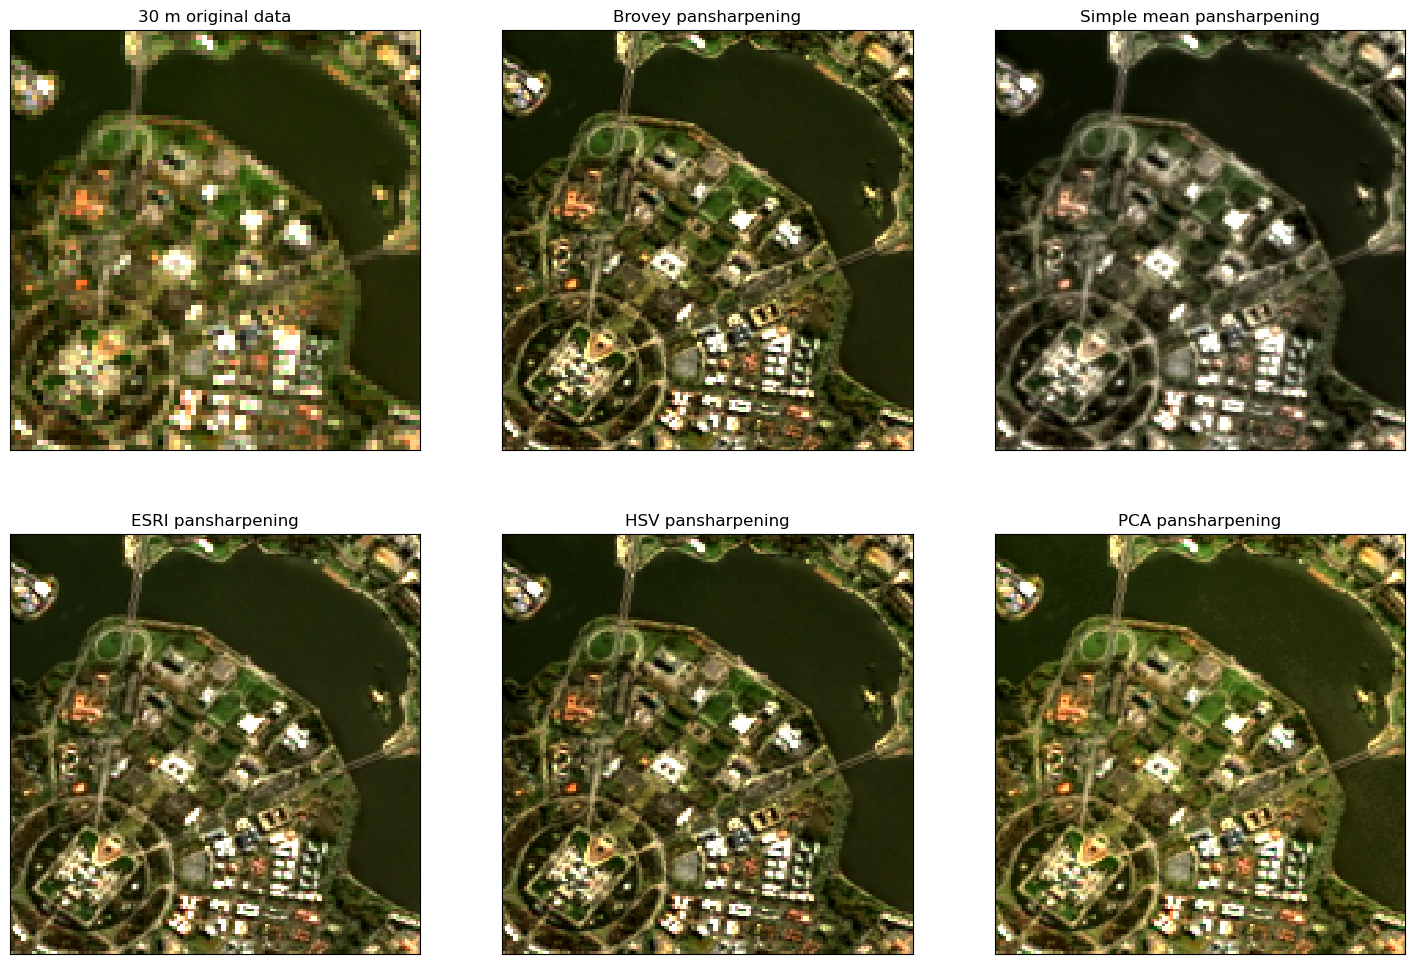

In [11]:
# Create empty 2 x 3 figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot each pansharpening method in RGB
rgb(ds=rgb_30m, ax=axes[0])
rgb(ds=rgb_brovey_15m, ax=axes[1])
rgb(ds=rgb_simplemean_15m, ax=axes[2])
rgb(ds=rgb_esri_15m, ax=axes[3])
rgb(ds=rgb_hsv_15m, ax=axes[4])
rgb(ds=rgb_pca_15m, ax=axes[5])

# Add titles to plots
axes[0].set_title("30 m original data")
axes[1].set_title("Brovey pansharpening")
axes[2].set_title("Simple mean pansharpening")
axes[3].set_title("ESRI pansharpening")
axes[4].set_title("HSV pansharpening")
axes[5].set_title("PCA pansharpening")

# Hide x and y axis labels
for ax in axes:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

## Pansharpening multiple timesteps/images
The `xr_pansharpen` function can be used to automatically apply pansharpening to every timestep in an `xr.Dataset`. 
For example, we might have a time series containing three timesteps of Landsat 8 imagery like the example below:

Finding datasets
    ga_ls8c_ard_3
Loading 3 time steps
Finding datasets
    ga_ls8c_ard_3
Loading 3 time steps


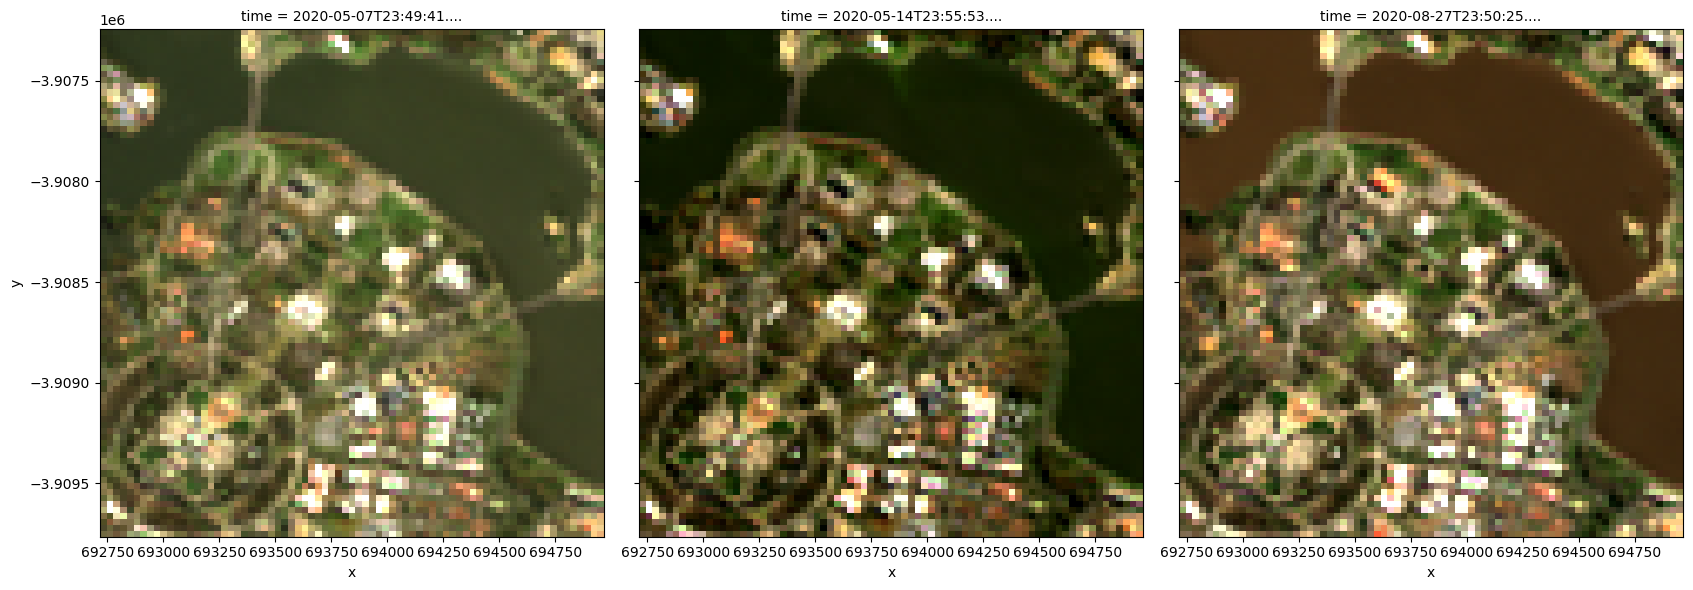

In [12]:
query = {
    "x": (149.12, 149.144),
    "y": (-35.312, -35.29),
    "time": ("2020-05", "2020-08"),
    "cloud_cover": (0, 10)  # Keep only mostly cloud free images
}

# Load red, green, blue and panchromatic band data at 15 m resolution
rgbp_15m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

# For reference, load the same image at 30 m resolution
rgb_30m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

# Plot our original 30 m true colour images
rgb(rgb_30m, col="time")

To apply pansharpening to each image, simply provide it to the `xr_pansharpen` function in the same way as a dataset with one image: 

Applying PCA pansharpening


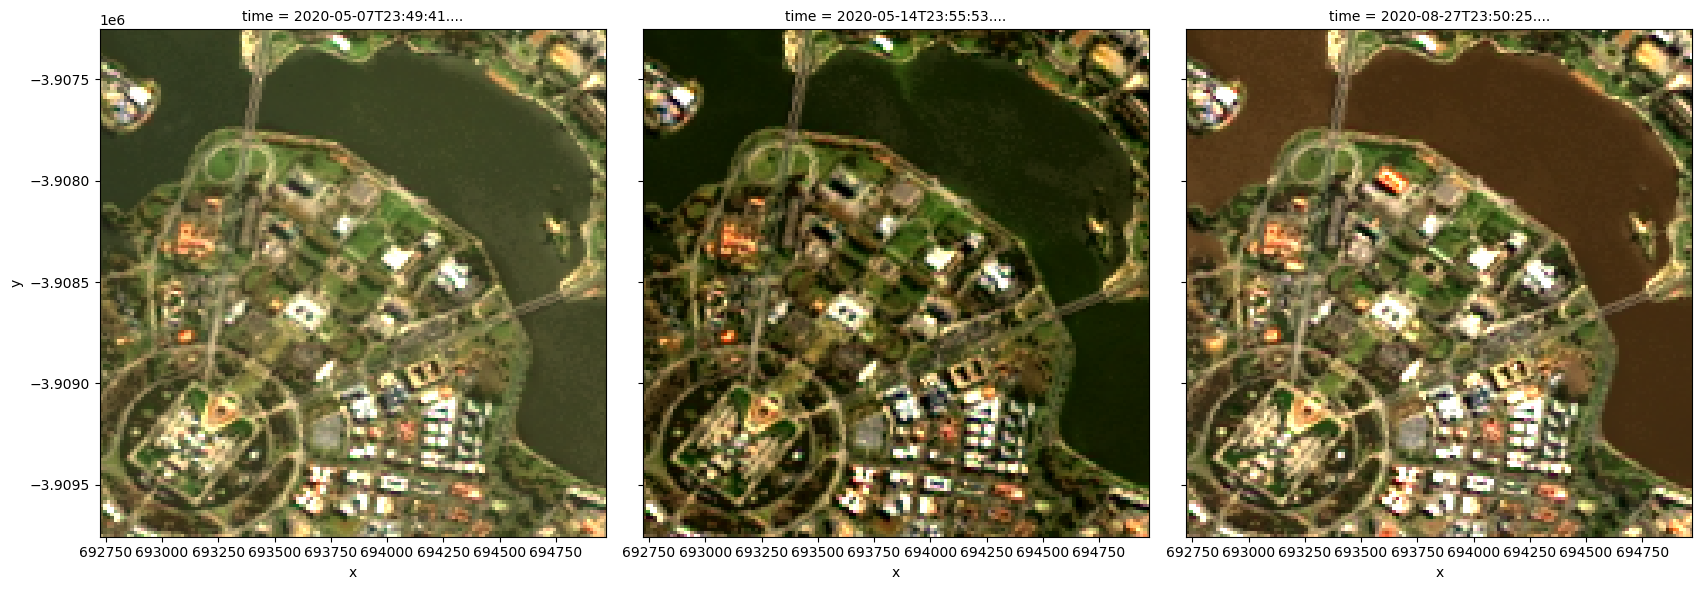

In [13]:
# Perform PCA pansharpening 
rgb_pca_15m = xr_pansharpen(rgbp_15m, transform="pca")

# Plot our pansharpened 15 m true colour images
rgb(rgb_pca_15m, col="time")

## Pansharpening Landsat 7

We can also use `xr_pansharpen` to pansharpen Landsat 7 imagery.
However, it is important to note that the Landsat 7's panchromatic band is different to the Landsat 8 and 9 panchromatic band: instead of overlapping with the Red, Green and Blue multispectral bands, Landsat 7's panchromatic band overlaps with the Near Infrared (NIR, or Landsat 7 Band 4), Red and Green bands.

This is shown on the diagram below; the panchromatic bands are shown as grey-coloured stripes labelled "8" on the left:

![Landsat bands](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/media/images/LandsatSpectralBands_20240319.png?itok=Fs2BUq1k)

Because of this difference, we can't use pansharpening to properly improve the resolution of Landsat 7's Blue band.
However, we _can_ use pansharpening to improve the resolution of the NIR band, which isn't possible for Landsat 8 and 9!

In this example below, we will load Landsat 7 data from the NIR, Red and Green bands and plot the result as a false colour image. 


Finding datasets
    ga_ls7e_ard_3
Applying contiguity mask (oa_nbart_contiguity)
Loading 3 time steps
Finding datasets
    ga_ls7e_ard_3
Applying contiguity mask (oa_nbart_contiguity)
Loading 3 time steps


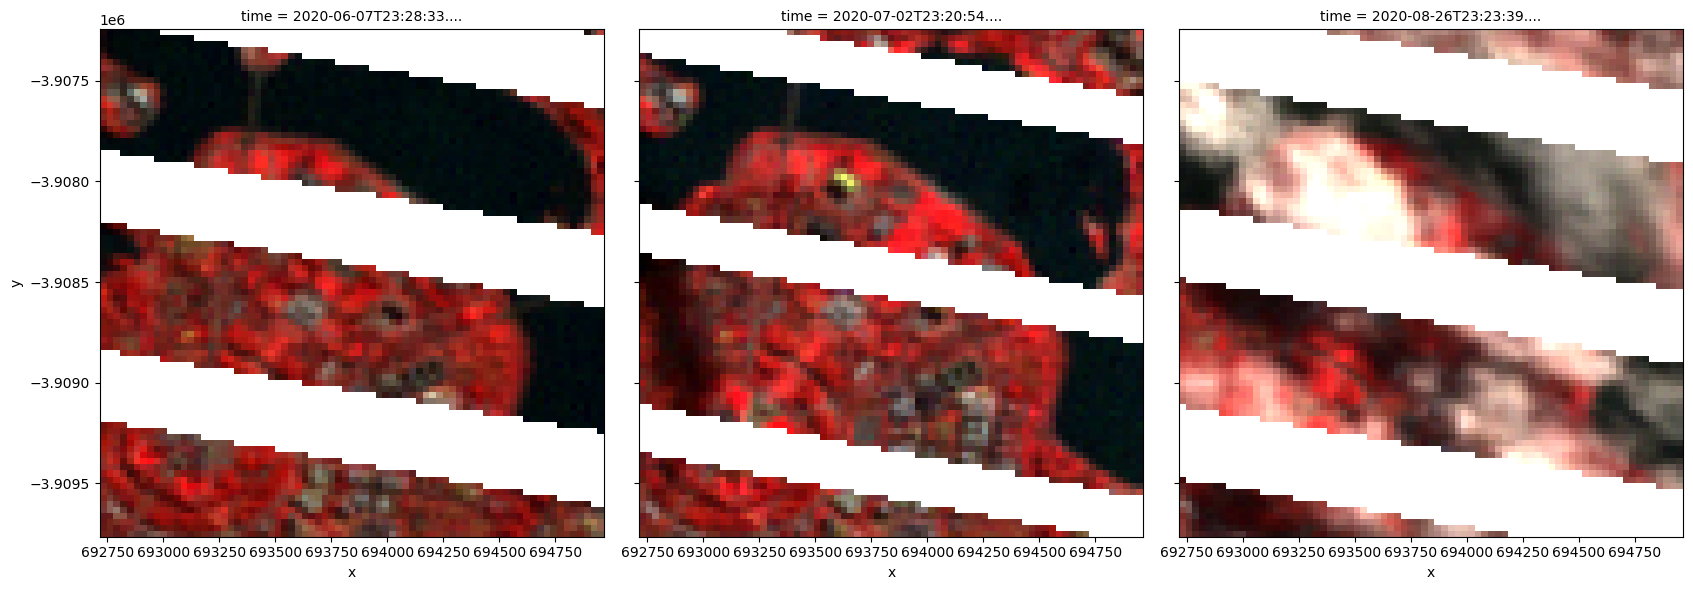

In [14]:
# Load NIR, red, green and panchromatic band data at 15 m resolution
nrgp_15m = load_ard(dc=dc,
    products=["ga_ls7e_ard_3"],
    measurements=["nbart_nir", "nbart_red", "nbart_green", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    mask_contiguity=True,
    **query
)

# For reference, load the same image at 30 m resolution
nrg_30m = load_ard(dc=dc,
    products=["ga_ls7e_ard_3"],
    measurements=["nbart_nir", "nbart_red", "nbart_green"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    mask_contiguity=True,
    **query
)

# Plot our original 30 m false colour images
rgb(nrg_30m, bands=["nbart_nir", "nbart_red", "nbart_green"], col="time")

We can now apply pansharpening to produce a higher resolution, pansharpened, false colour dataset:

Applying PCA pansharpening


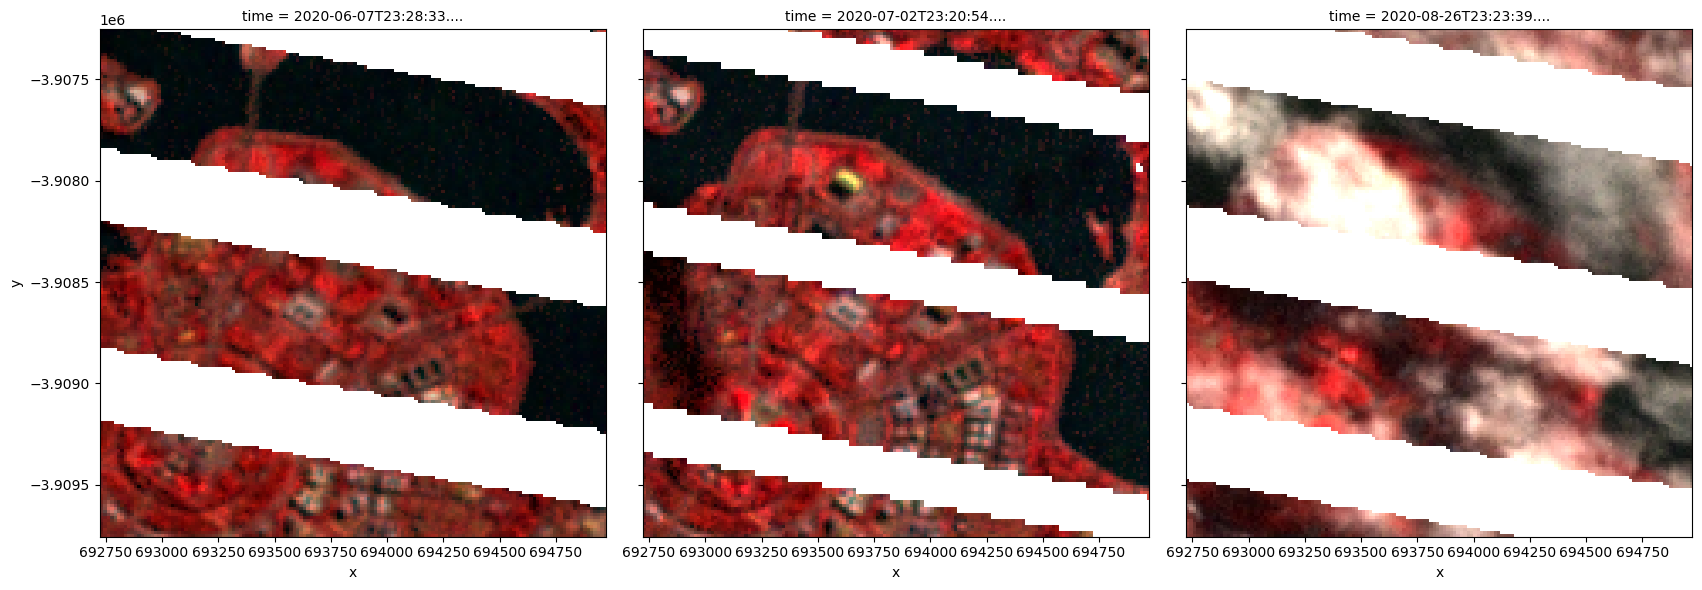

In [15]:
# Perform PCA pansharpening on NIR, Red and Green band data
nrg_pca_15m = xr_pansharpen(nrgp_15m, transform="pca")

# Plot our pansharpened 15 m false colour images
rgb(nrg_pca_15m, bands=["nbart_nir", "nbart_red", "nbart_green"], col="time")

> **Note:** Some pansharpening methods like HSV are only appropriate for use on data containing RGB bands (i.e. red, green, blue), so are unlikely to produce good results if applied to Landsat 7 data.

## Advanced

### Evaluating pansharpening method performance

To help choose between different pansharpening transforms, it can be useful to evaluate how they perform across two unique aspects:

* **Spectral performance**: how well they preserve the multispectral values in the low resolution multispectral bands
* **Spatial performance**: how well they capture the additional spatial detail in the high resolution panchromatic bands

The following section provides an example of how we could compare the spatial and spectral performance of our pansharpening transforms using two indices.
These are only two of many indices that can be used to compare pansharpening performance. 
For more potential options, refer to [Alcaras et al. 2021](https://www.mdpi.com/2072-4292/13/8/1550#B86-remotesensing-13-01550).

* **Spectral correlation co-efficient:** This measures the correlation between the original multispectral data and our pansharpened data. High correlations indicate that the pansharpening transform has preserved the spectra in our original data. 
* **Zhou's spatial index:** This index uses a Laplacian filter to extract high frequency information from both the panchromatic band and each of our pansharpened bands, then compares their correlation.
The resulting high frequency layers can be thought of as a form of edge detection that captures most of the image's spatial structure while excluding multispectral variation. 
High correlations indicate that the pansharpened data captures the extra spatial detail contained in the panchromatic band.

First of all, we select a single timestep of imagery:


In [16]:
# Select a single image from our original 30 m data and
# our 15 m resampled (but not pansharpened) data
timestep = 0
ds_30m_i = rgb_30m.isel(time=timestep)
ds_15m_i = rgbp_15m.isel(time=timestep)

Now we extract our high frequency information from our panchromatic dataset:

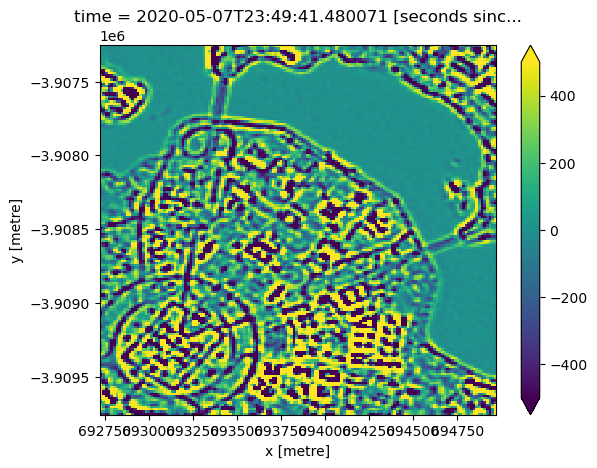

In [17]:
# Laplacian kernel
kernel = np.array([[1, 1, 1], 
                   [1, -8, 1], 
                   [1, 1, 1]])

# Smooth data using Guassian blur to some reduce high frequency noise, 
# then apply Laplacian filter
blurred_img = cv2.GaussianBlur(ds_15m_i.nbart_panchromatic.values, (3, 3), 0)
panband_highfreq = cv2.filter2D(blurred_img, ddepth=-1, kernel=kernel)
panband_highfreq_da = xr.DataArray(panband_highfreq, coords=ds_15m_i.coords)
panband_highfreq_da.plot(vmin=-500, vmax=500)

Now we can loop through each of our pansharpening methods, and do the following:
    
* Extract similar high frequency information from each of our pansharpened bands, then calculate Zhou's spatial index by correlating these against the high frequency information from our panchromatic dataset
* Calculate a spectral correlation coefficient by correlating our pansharpened data against our original 30 m multispectral data
* Return our metrics as `pandas.DataFrames` that we can easily plot and compare

In [18]:
output_list = []

for transform in ["brovey", "esri", "simple mean", "hsv", "pca"]:

    # Apply pansharpening
    pansharpened_i = xr_pansharpen(ds_15m_i, transform=transform)

    # Transpose data so it is suitable as an input for image processing
    # functions that require data in a 3D array with band on the final axis
    pansharpened_reshaped = (pansharpened_i
                             .to_array()
                             .transpose(..., "variable"))

    # Apply Guassian filter to blur image, then compute high frequency
    # Laplacian filter across each multispectral band
    blurred_img = cv2.GaussianBlur(pansharpened_reshaped.values, (3, 3), 0)
    pansharpened_highfreq = cv2.filter2D(
        blurred_img,
        ddepth=-1,
        kernel=kernel,
    )

    # Convert to xarray
    pansharpened_highfreq_da = xr.DataArray(pansharpened_highfreq,
                                            coords=pansharpened_reshaped.coords)

    # Calculate Zhou's spatial index by correlating high frequency
    # information from panchromatic band against each of our pansharped
    # bands.
    spatial_corr_df = (xr.corr(panband_highfreq_da,
                               pansharpened_highfreq_da,
                               dim=["x",
                                    "y"]).to_dataframe(name="value").assign(
                                        transform=transform, type='spatial'))

    # Calculate spectral correlation co-efficient by correlating
    # our pansharped data against our original 30 m multispectral
    # data. So that both datasets line up nicely, we first need to
    # interpolate our 30 m data to 15 m using "nearest" resampling
    ds_30m_i_interp = ds_30m_i.interp_like(pansharpened_i, method='nearest')
    spectral_corr_df = (xr.corr(pansharpened_i.to_array(),
                                ds_30m_i_interp.to_array(),
                                dim=["x",
                                     "y"]).to_dataframe(name="value").assign(
                                         transform=transform, type='spectral'))

    # Append dataframes to list
    output_list.append(spectral_corr_df)
    output_list.append(spatial_corr_df)

Applying Brovey pansharpening
Applying Esri pansharpening
Applying Simple mean pansharpening
Applying HSV pansharpening
Applying PCA pansharpening


Now we can plot our spatial and spectral statistics as a scatter plot for each of our multispectral bands to compare how each of our pansharpening transforms performed. 

In this location, we can see that the Simple Mean transform did well at preserving spectral information but poorly at capturing spatial information; ESRI, Brovey and HSV did well at spatial but less well spectrally, and PCA performed reasonably well across both.

> **Note:** These results are specific to this study area and shouldn't be generalised to other regions; pansharpening transforms are likely to perform differently in different environments (e.g. coastal, arid, urban, vegetation, crops etc).

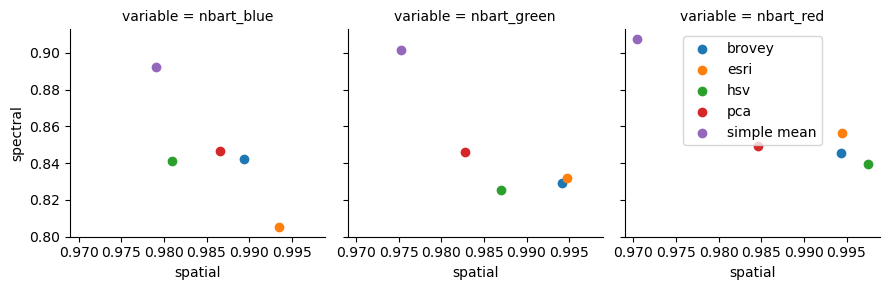

In [19]:
# Combine into a single dataframe and reshape so that 
# we have a spatial and spectral column
pansharpening_stats_df = (pd.concat(output_list)
                          .drop(['time', 'spatial_ref'], axis=1)
                          .reset_index()
                          .pivot(index=['transform', 'variable'], 
                                 columns=['type'], 
                                 values='value'))

# Plot as a faceted seaborn plot
g = sns.FacetGrid(pansharpening_stats_df.reset_index(), col='variable', hue='transform')
g = g.map(plt.scatter, "spatial", "spectral")
plt.legend()

In [20]:
# Print statistics
pansharpening_stats_df.round(2)

type                     spatial  spectral
transform   variable                      
brovey      nbart_blue      0.99      0.84
            nbart_green     0.99      0.83
            nbart_red       0.99      0.85
esri        nbart_blue      0.99      0.81
            nbart_green     0.99      0.83
            nbart_red       0.99      0.86
hsv         nbart_blue      0.98      0.84
            nbart_green     0.99      0.83
            nbart_red       1.00      0.84
pca         nbart_blue      0.99      0.85
            nbart_green     0.98      0.85
            nbart_red       0.98      0.85
simple mean nbart_blue      0.98      0.89
            nbart_green     0.98      0.90
            nbart_red       0.97      0.91

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.19


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->